In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import copy
import random
import warnings
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings('ignore')

random.seed(42)

In [ ]:
df = pd.read_csv('./owid-covid-data.csv',index_col=0)
df.info()
filterX = ['new_cases',"weekly_new_cases_average","weekly_new_tests_average","positive_rate","total_vaccinations","people_vaccinated","people_fully_vaccinated","stringency_index"]
filterY = ['new_cases']
df = df[filterX]
df1 = copy.deepcopy(df)
df1["total_vaccinations"] = df1["total_vaccinations"].fillna(0)
df1["people_vaccinated"] = df1["people_vaccinated"].fillna(0)
df1["people_fully_vaccinated"] = df1["people_fully_vaccinated"].fillna(0)


<class 'pandas.core.frame.DataFrame'>
Index: 416 entries, 2020-03-01 to 2021-04-20
Data columns (total 29 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   total_cases                                           416 non-null    int64  
 1   new_cases                                             416 non-null    int64  
 2   weekly_new_cases_average                              416 non-null    int64  
 3   new_cases_yesterday                                   416 non-null    int64  
 4   new_deaths                                            416 non-null    int64  
 5   weeky_new_deaths_average                              416 non-null    int64  
 6   new_deaths_yesterday                                  416 non-null    int64  
 7   new_tests                                             416 non-null    int64  
 8   weekly_new_tests_average                         

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416 entries, 2020-03-01 to 2021-04-20
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   new_cases                 416 non-null    int64  
 1   weekly_new_cases_average  416 non-null    int64  
 2   weekly_new_tests_average  416 non-null    int64  
 3   positive_rate             416 non-null    float64
 4   total_vaccinations        416 non-null    int64  
 5   people_vaccinated         416 non-null    int64  
 6   people_fully_vaccinated   416 non-null    int64  
 7   stringency_index          416 non-null    float64
dtypes: float64(2), int64(6)
memory usage: 29.2+ KB


In [ ]:
df = df.astype(float)

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(df)
df_train = scaler.transform(df)

scaler2 = StandardScaler()
scaler2 = scaler2.fit(df1)
df_train2 = scaler2.transform(df1)

In [ ]:
def set_shape(fut):
    trainX = []
    trainY = []
    n_future = fut  # Number of days we want to predict into the future
    n_past = 7     # Number of past days we want to use to predict the future


    for i in range(n_past, len(df_train) - n_future +1):
        trainX.append(df_train[i - n_past:i, 0:df_train.shape[1]])
        trainY.append(df_train[i + n_future - 1:i + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))
    return trainX,trainY

In [ ]:
def set_shape2(fut):
    trainX = []
    trainY = []
    n_future = fut  # Number of days we want to predict into the future
    n_past = 7     # Number of past days we want to use to predict the future


    for i in range(n_past, len(df_train2) - n_future +1):
        trainX.append(df_train2[i - n_past:i, 0:df_train.shape[1]])
        trainY.append(df_train2[i + n_future - 1:i + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))
    return trainX,trainY

In [ ]:

def test_train_split(trainX, trainY):
    testX = trainX[-60:]
    testY = trainY[-60:]

    trainX = trainX[:-60]
    trainY = trainY[:-60]

    trainDates = df1.index[:-60]
    testDates = df1.index[-60:]

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))

    print('testX shape == {}.'.format(testX.shape))
    print('testY shape == {}.'.format(testY.shape))
    return testX,testY,trainDates,testDates,trainX,trainY

In [ ]:
def plot(classifiers_names, evaluation):
    fig, axs = plt.subplots(1,3, figsize=(20, 5))
    axs = axs.ravel()

    # print(classifiers_names)

    for i in range(3):
        axs[i].bar(classifiers_names,evaluation[i])
        for tick in axs[i].get_xticklabels():
            tick.set_rotation(90)
    axs[0].set_title('MSE')
    axs[1].set_title('MAE')
    axs[2].set_title('R2')
    plt.show()

In [ ]:
def predict_n_days(trainX, trainY, testX, testY, testDates,n):

    classifiers = [
        svm.SVR(),
        linear_model.SGDRegressor(random_state=42),
        GradientBoostingRegressor(random_state=42),
        linear_model.ARDRegression(),
        RandomForestRegressor(random_state = 42),
        linear_model.LinearRegression()]

    nsamples, nx, ny = trainX.shape
    train_new_dataset = trainX.reshape((nsamples,nx*ny))
    nsamples, nx, ny = testX.shape
    test_new_dataset = testX.reshape((nsamples,nx*ny))


    df1['Date'] = pd.to_datetime(df1.index)

    fig, axs = plt.subplots(2,3, figsize=(30, 15))
    fig.suptitle(f'Predicting {n} day(s) ahead in the future',fontsize=30)
    classifiers_names = ['svm','SGDRegressor','GradientBoostingRegressor','ARDRegression','RandomForestRegressor','LinearRegression']

    MSE_scores = []
    MAE_scores = []
    R2_scores = []

    axs = axs.ravel()   

    i=0
    for item in classifiers:
        clf = item
        clf.fit(train_new_dataset, trainY.ravel())
        forecast = (clf.predict(test_new_dataset))
        forecast = forecast.reshape(len(forecast), 1, 1)
        forecast_copies = np.repeat(forecast, df_train.shape[1], axis=-1)
        y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
        y_pred_future = y_pred_future[:,0]
        df_forecast = pd.DataFrame({'Date':testDates, 'Cases':y_pred_future})
        df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
        axs[i].set_title(classifiers_names[i])
        axs[i].set_ylabel('Cases')
        testY_new = scaler.inverse_transform(np.repeat(testY,df_train.shape[1], axis=-1))[:,0]
        axs[i].plot(df_forecast['Date'], testY_new)
        axs[i].plot(df_forecast['Date'], df_forecast['Cases'])
        for tick in axs[i].get_xticklabels():
            tick.set_rotation(45)
        i+=1
        R2_scores.append(r2_score(testY,forecast.reshape(len(forecast),1)))
        MSE_scores.append(mean_squared_error(testY,forecast.reshape(len(forecast),1)))
        MAE_scores.append(mean_absolute_error(testY,forecast.reshape(len(forecast),1)))

    plt.show()
    evaluation = [MSE_scores,MAE_scores,R2_scores]
    plot(classifiers_names, evaluation)

trainX shape == (409, 7, 8).
trainY shape == (409, 1).
trainX shape == (349, 7, 8).
trainY shape == (349, 1).
testX shape == (60, 7, 8).
testY shape == (60, 1).
trainX shape == (409, 7, 8).
trainY shape == (409, 1).
trainX shape == (349, 7, 8).
trainY shape == (349, 1).
testX shape == (60, 7, 8).
testY shape == (60, 1).


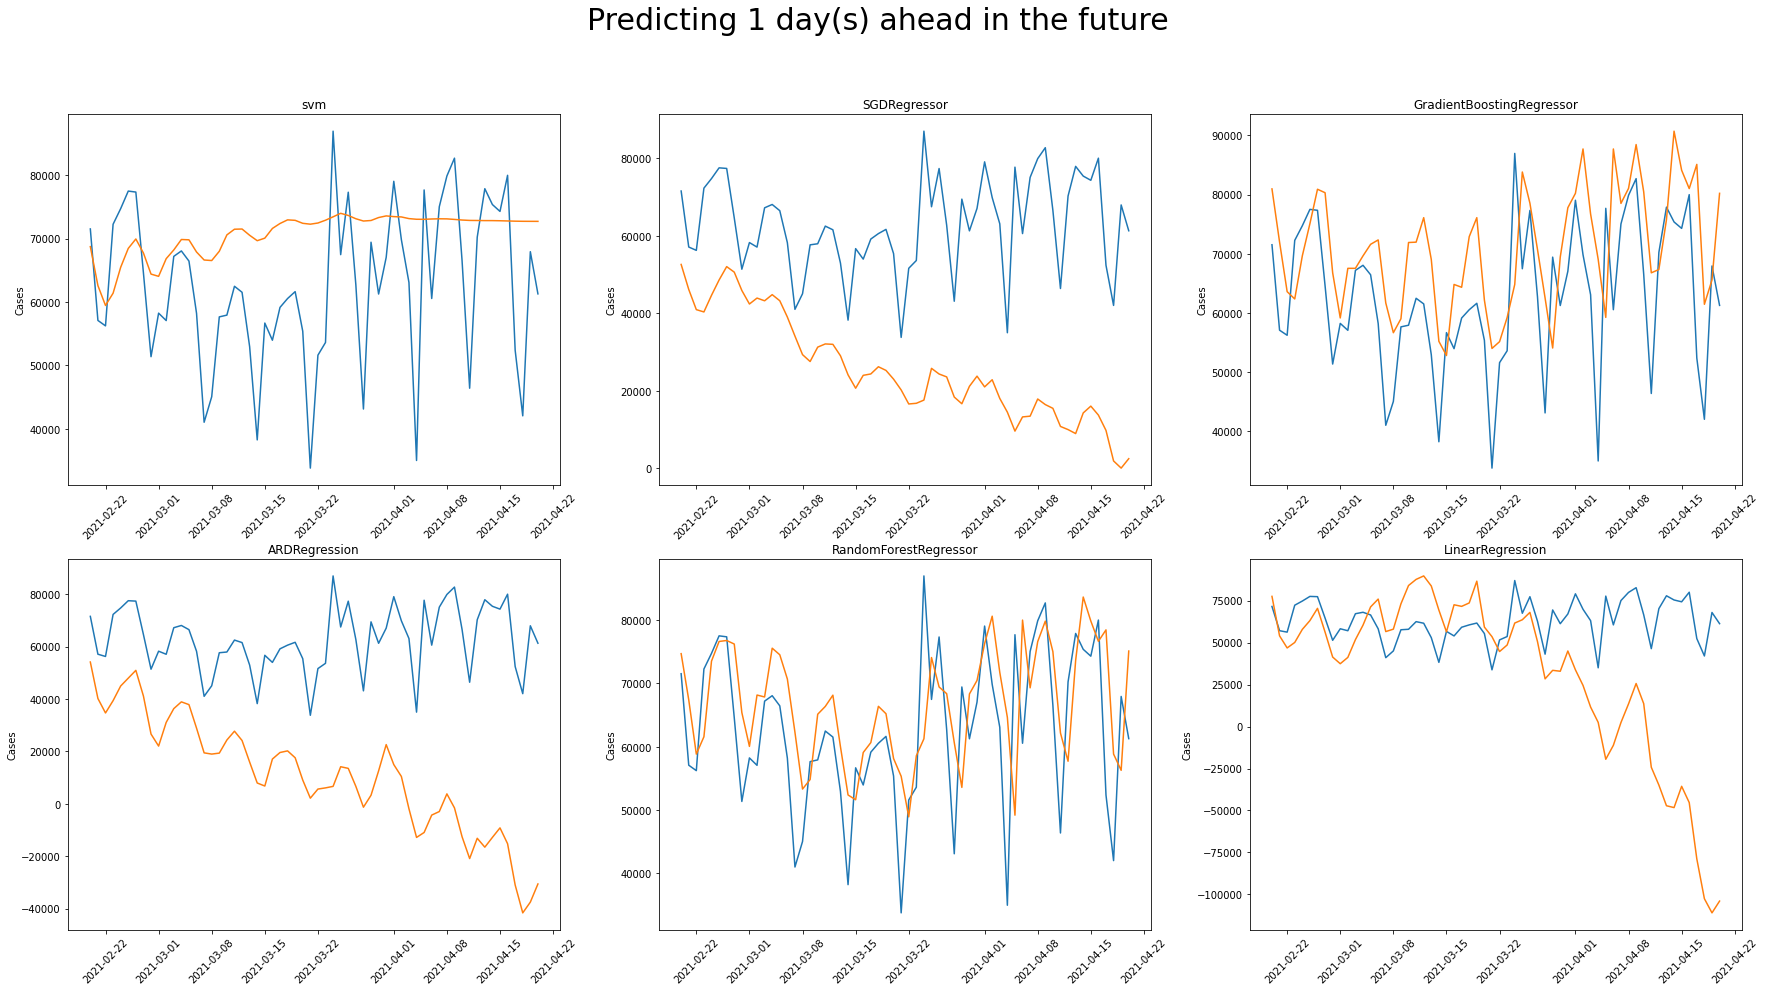

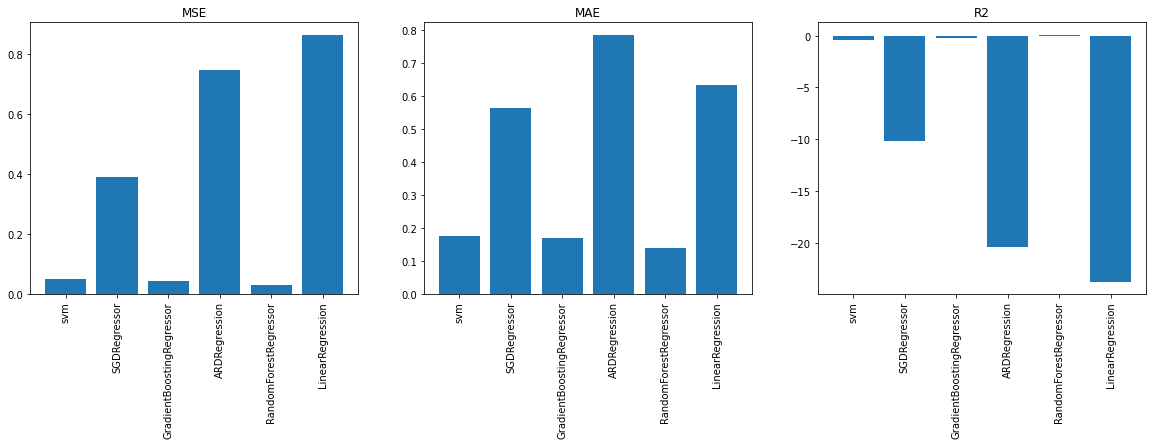

trainX shape == (408, 7, 8).
trainY shape == (408, 1).
trainX shape == (348, 7, 8).
trainY shape == (348, 1).
testX shape == (60, 7, 8).
testY shape == (60, 1).
trainX shape == (408, 7, 8).
trainY shape == (408, 1).
trainX shape == (348, 7, 8).
trainY shape == (348, 1).
testX shape == (60, 7, 8).
testY shape == (60, 1).


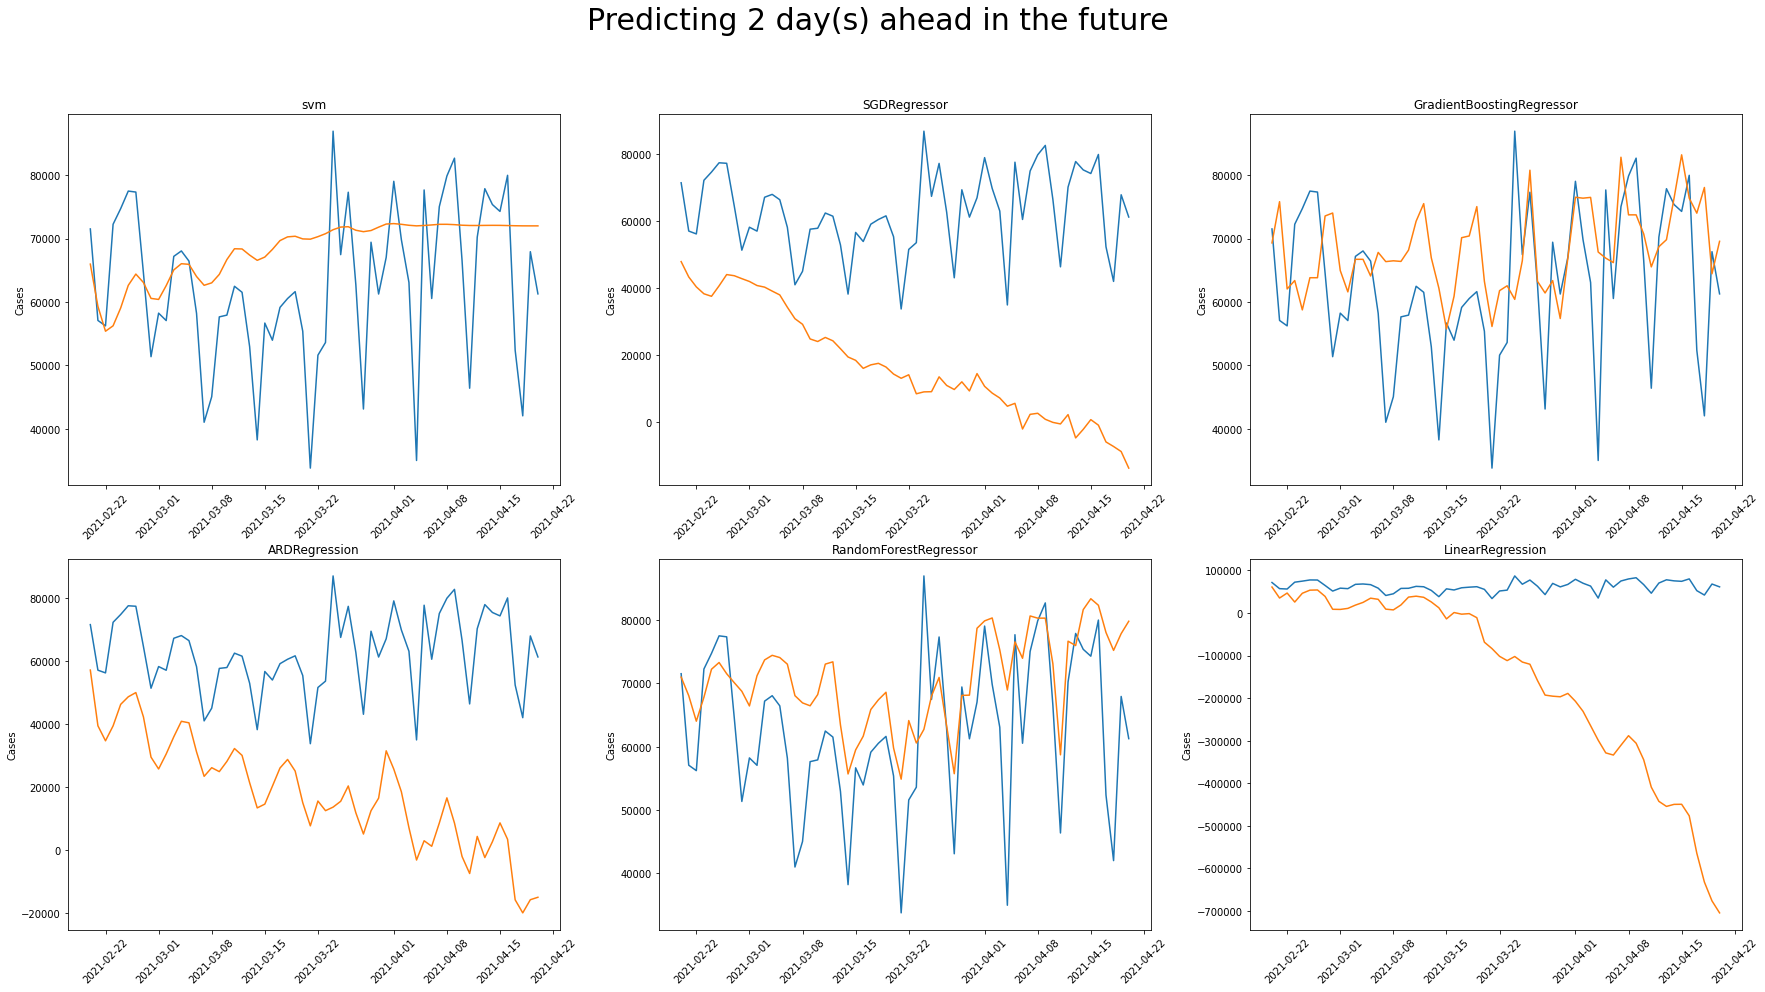

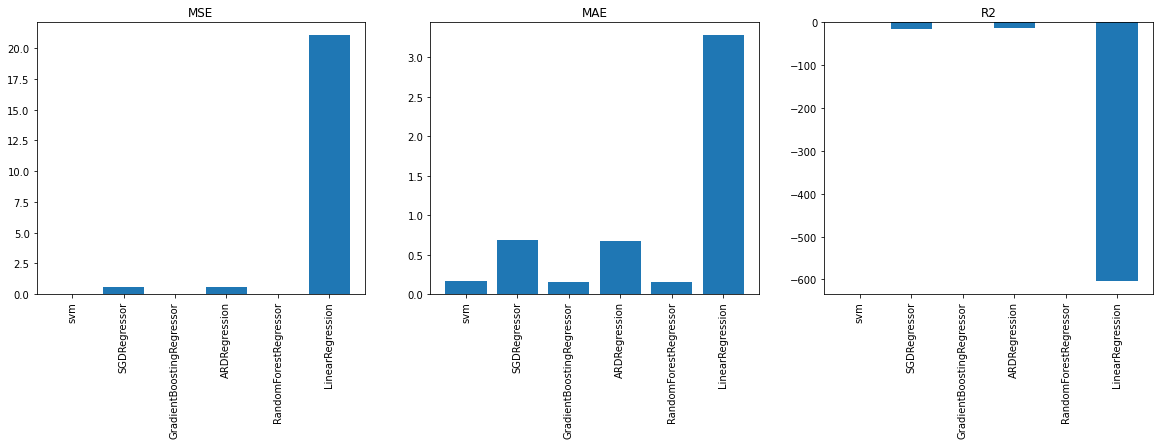

trainX shape == (407, 7, 8).
trainY shape == (407, 1).
trainX shape == (347, 7, 8).
trainY shape == (347, 1).
testX shape == (60, 7, 8).
testY shape == (60, 1).
trainX shape == (407, 7, 8).
trainY shape == (407, 1).
trainX shape == (347, 7, 8).
trainY shape == (347, 1).
testX shape == (60, 7, 8).
testY shape == (60, 1).


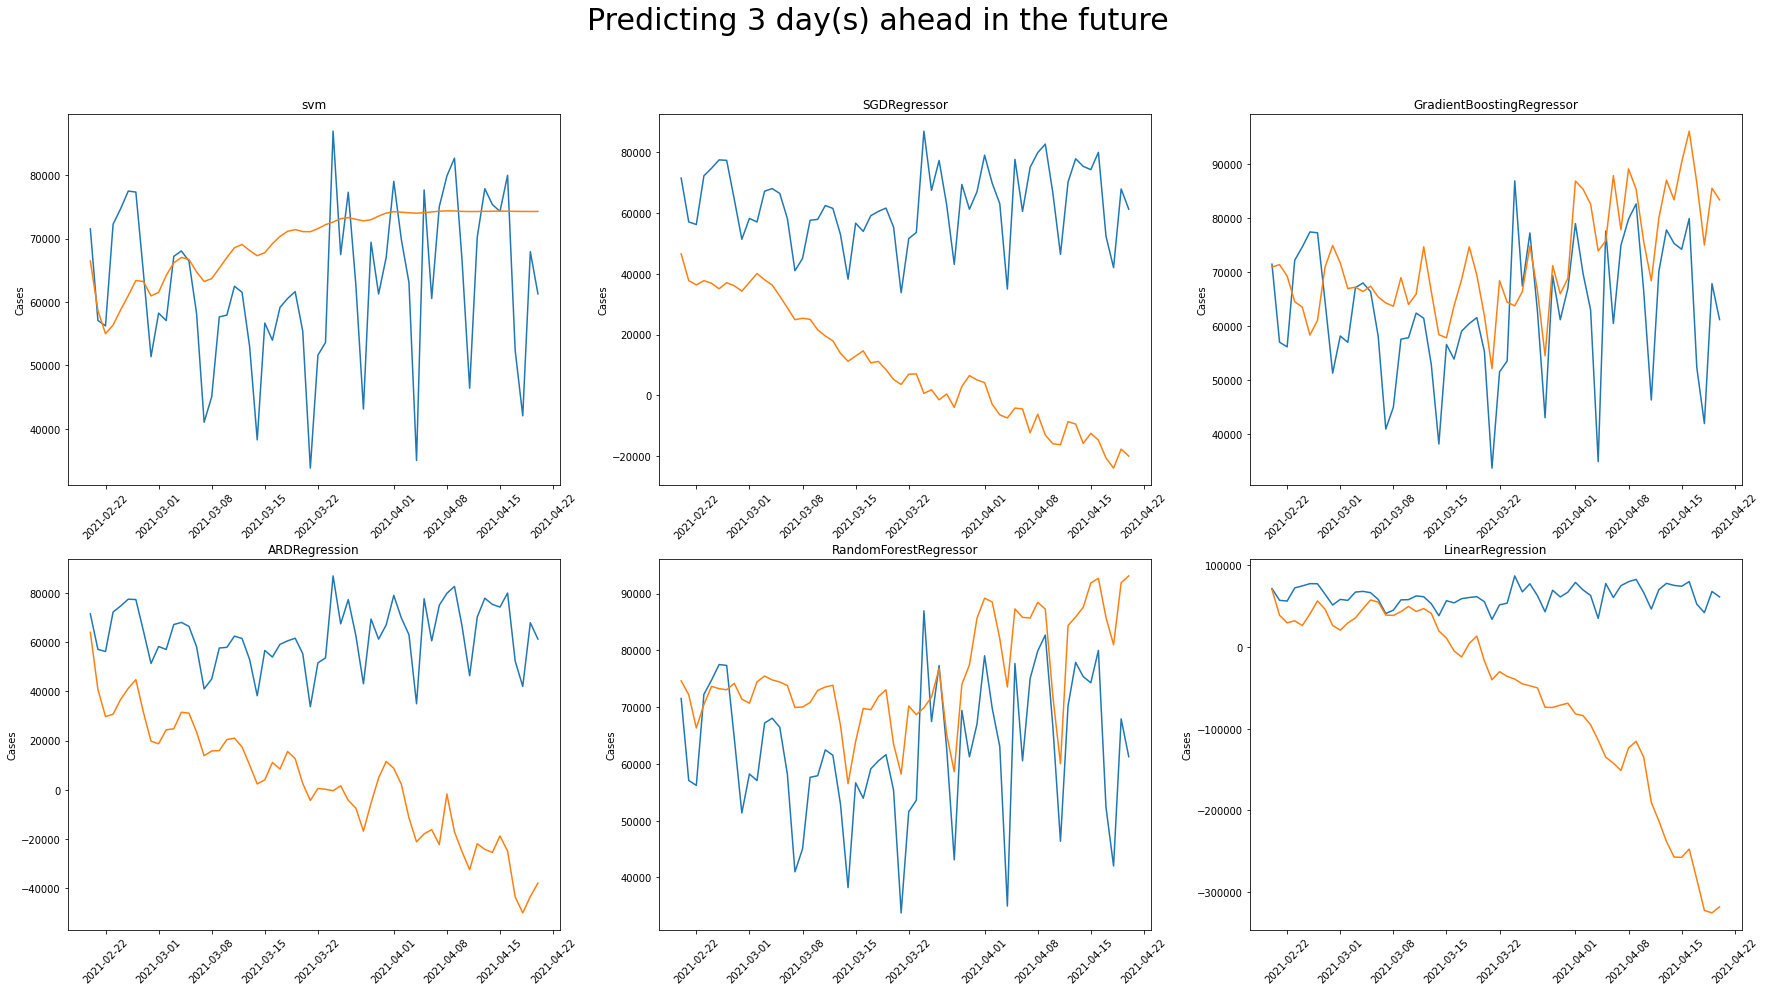

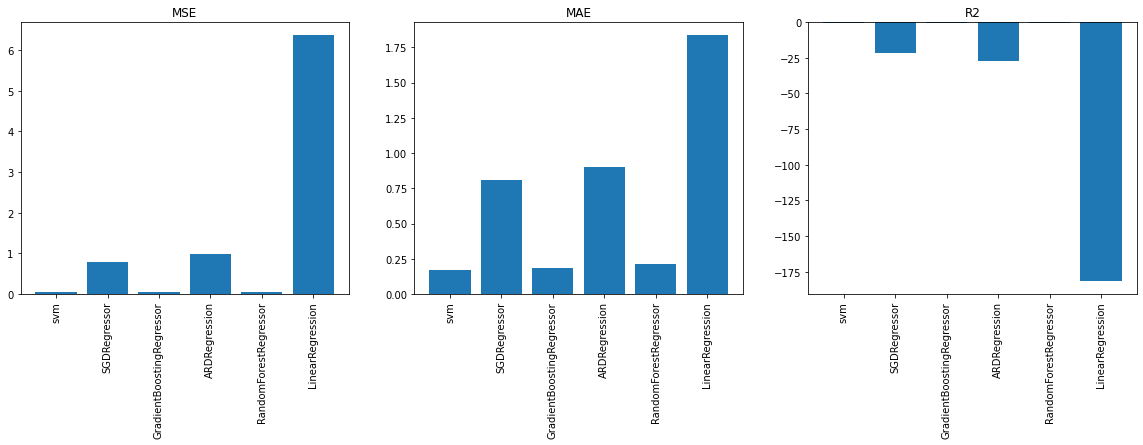

trainX shape == (406, 7, 8).
trainY shape == (406, 1).
trainX shape == (346, 7, 8).
trainY shape == (346, 1).
testX shape == (60, 7, 8).
testY shape == (60, 1).
trainX shape == (406, 7, 8).
trainY shape == (406, 1).
trainX shape == (346, 7, 8).
trainY shape == (346, 1).
testX shape == (60, 7, 8).
testY shape == (60, 1).


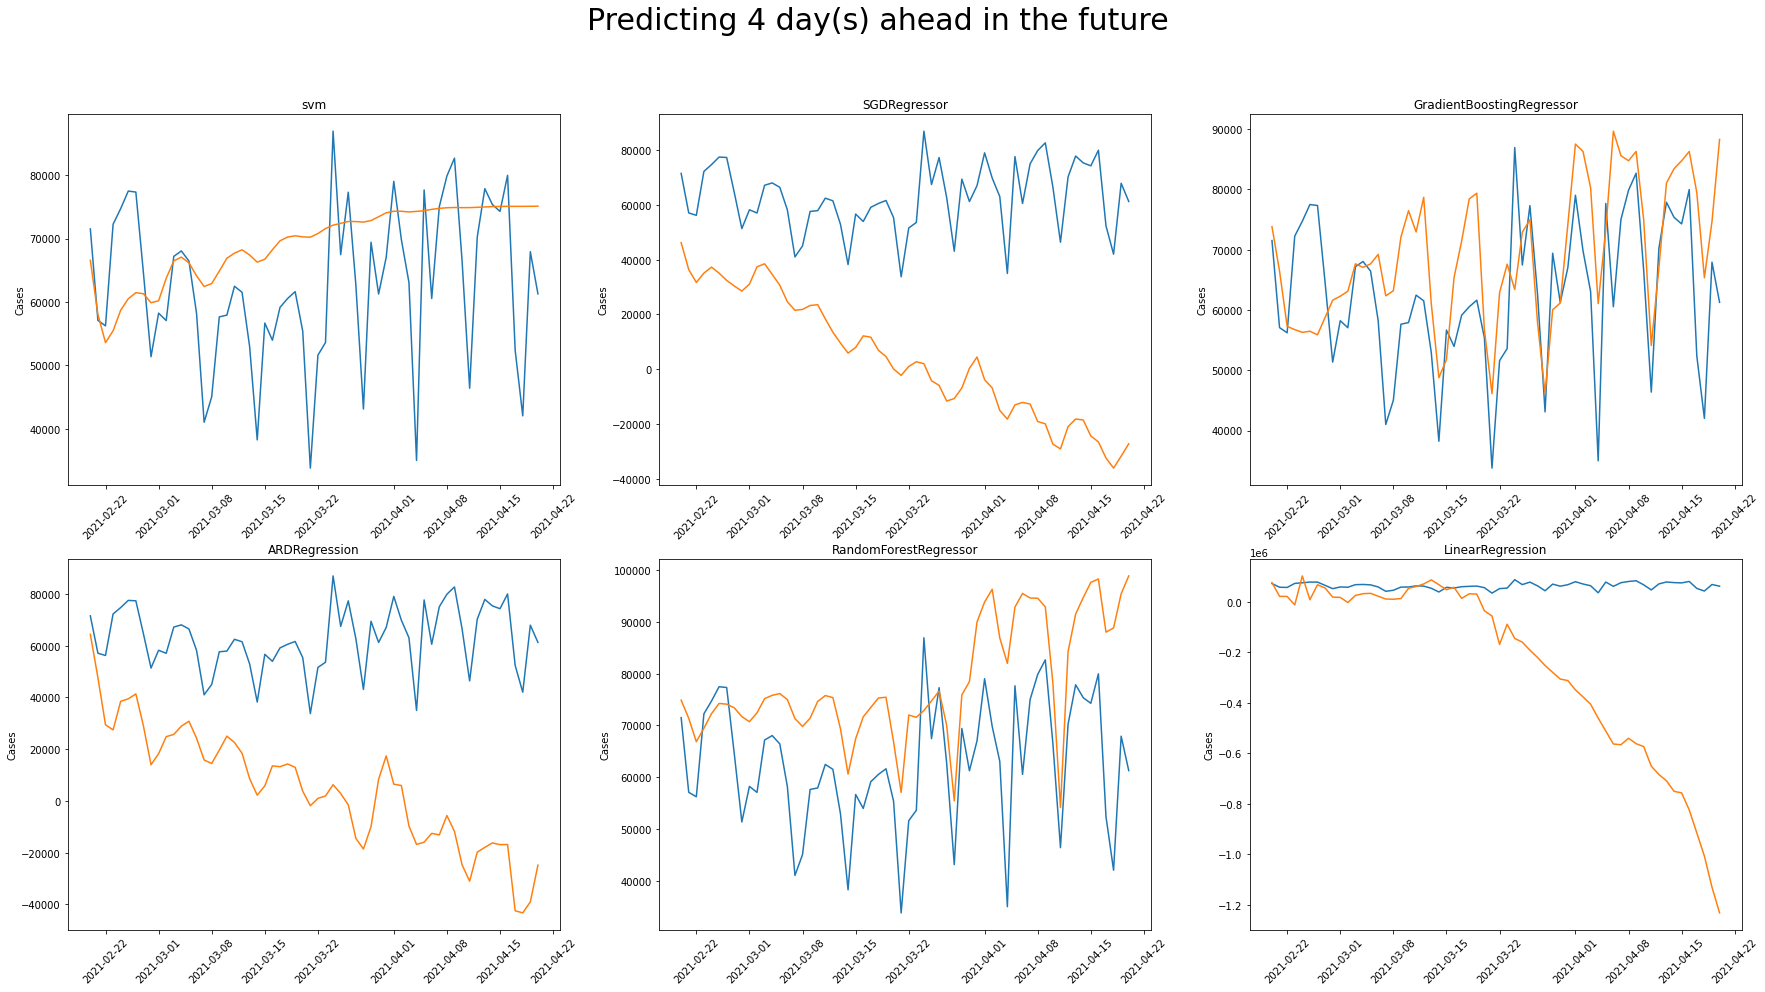

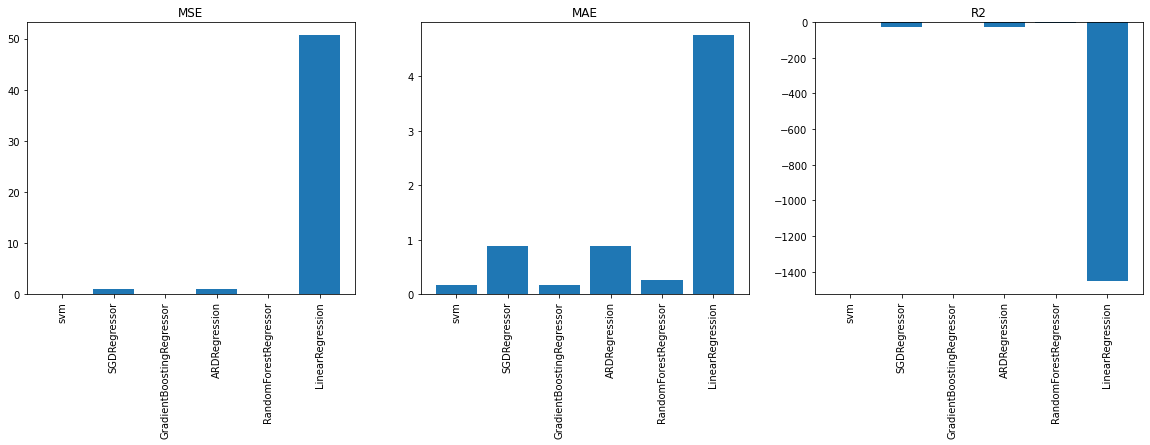

trainX shape == (405, 7, 8).
trainY shape == (405, 1).
trainX shape == (345, 7, 8).
trainY shape == (345, 1).
testX shape == (60, 7, 8).
testY shape == (60, 1).
trainX shape == (405, 7, 8).
trainY shape == (405, 1).
trainX shape == (345, 7, 8).
trainY shape == (345, 1).
testX shape == (60, 7, 8).
testY shape == (60, 1).


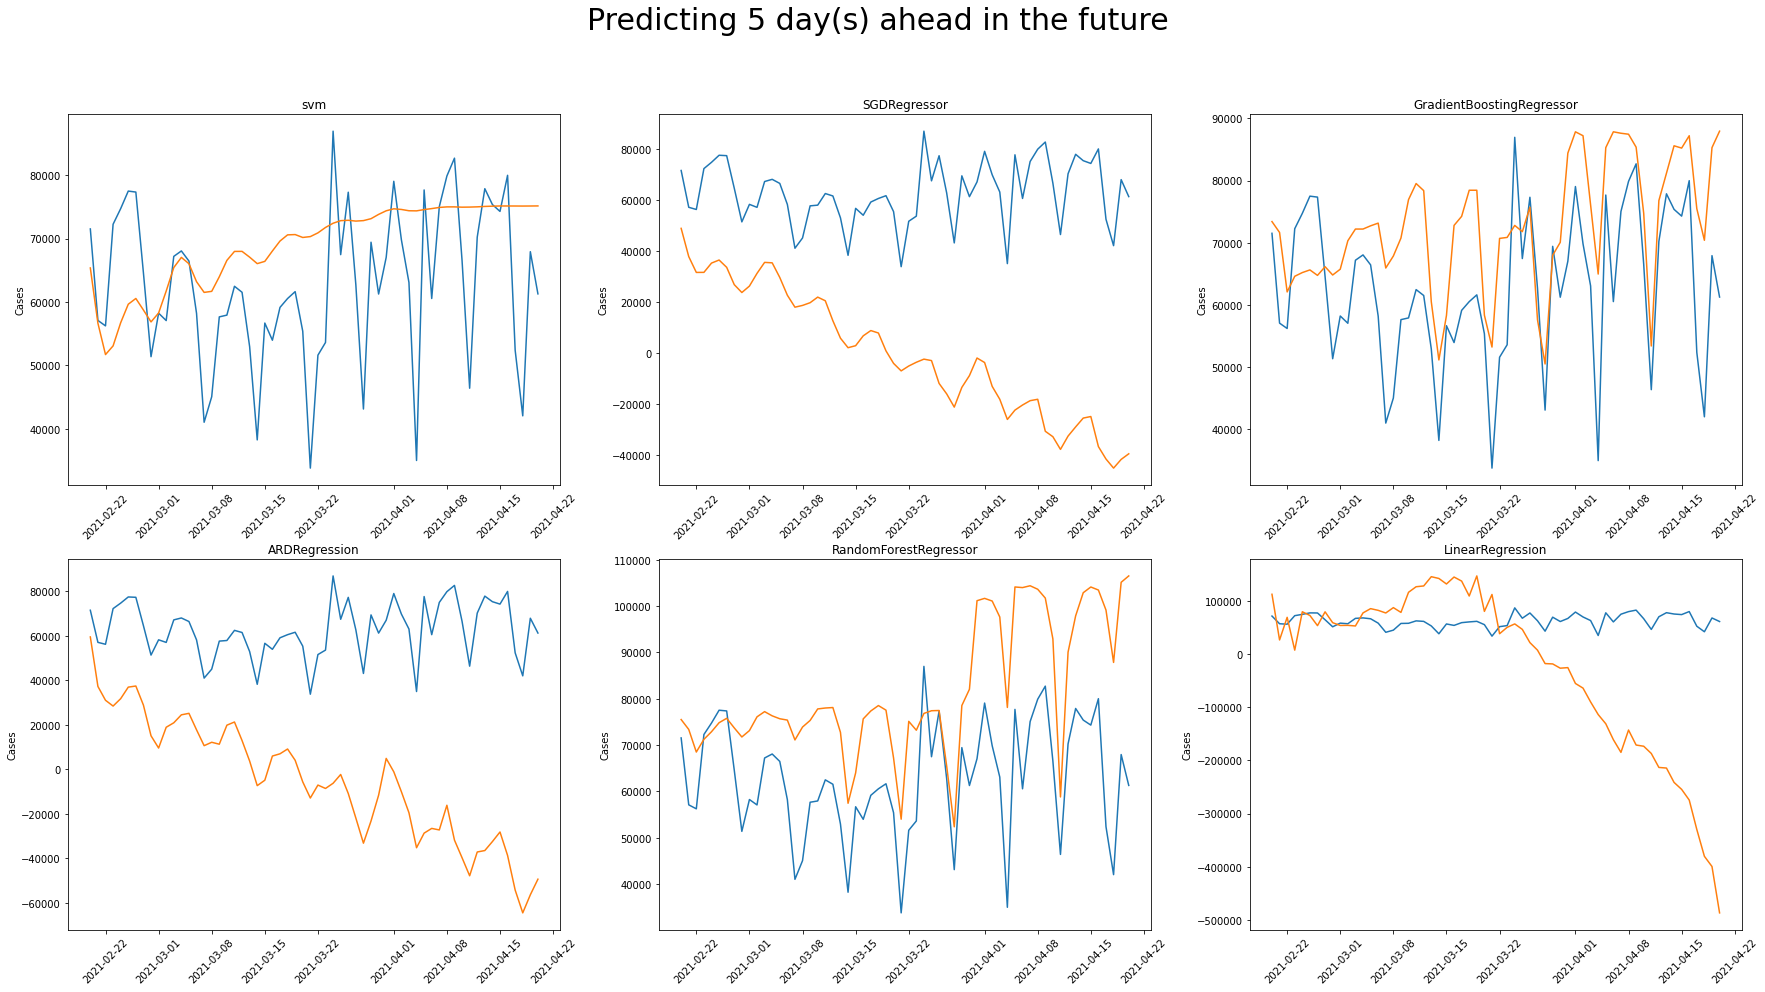

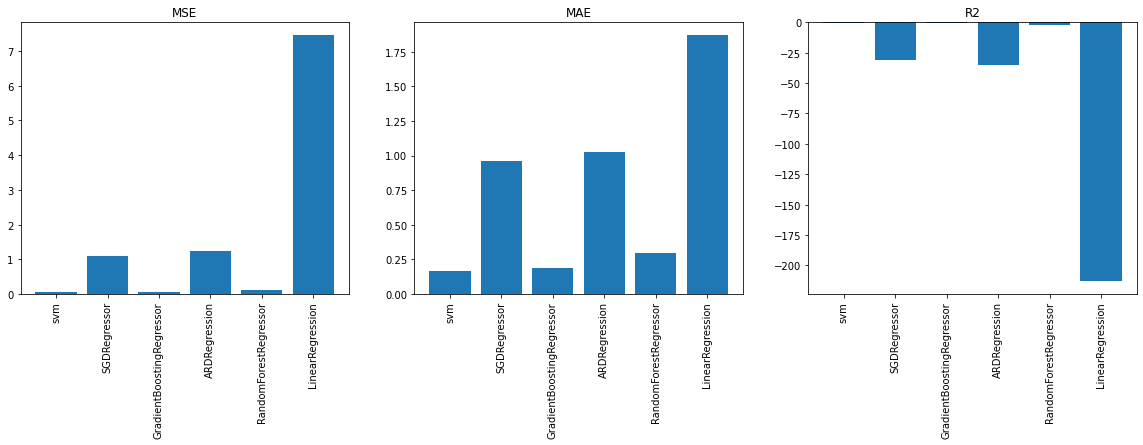

trainX shape == (404, 7, 8).
trainY shape == (404, 1).
trainX shape == (344, 7, 8).
trainY shape == (344, 1).
testX shape == (60, 7, 8).
testY shape == (60, 1).
trainX shape == (404, 7, 8).
trainY shape == (404, 1).
trainX shape == (344, 7, 8).
trainY shape == (344, 1).
testX shape == (60, 7, 8).
testY shape == (60, 1).


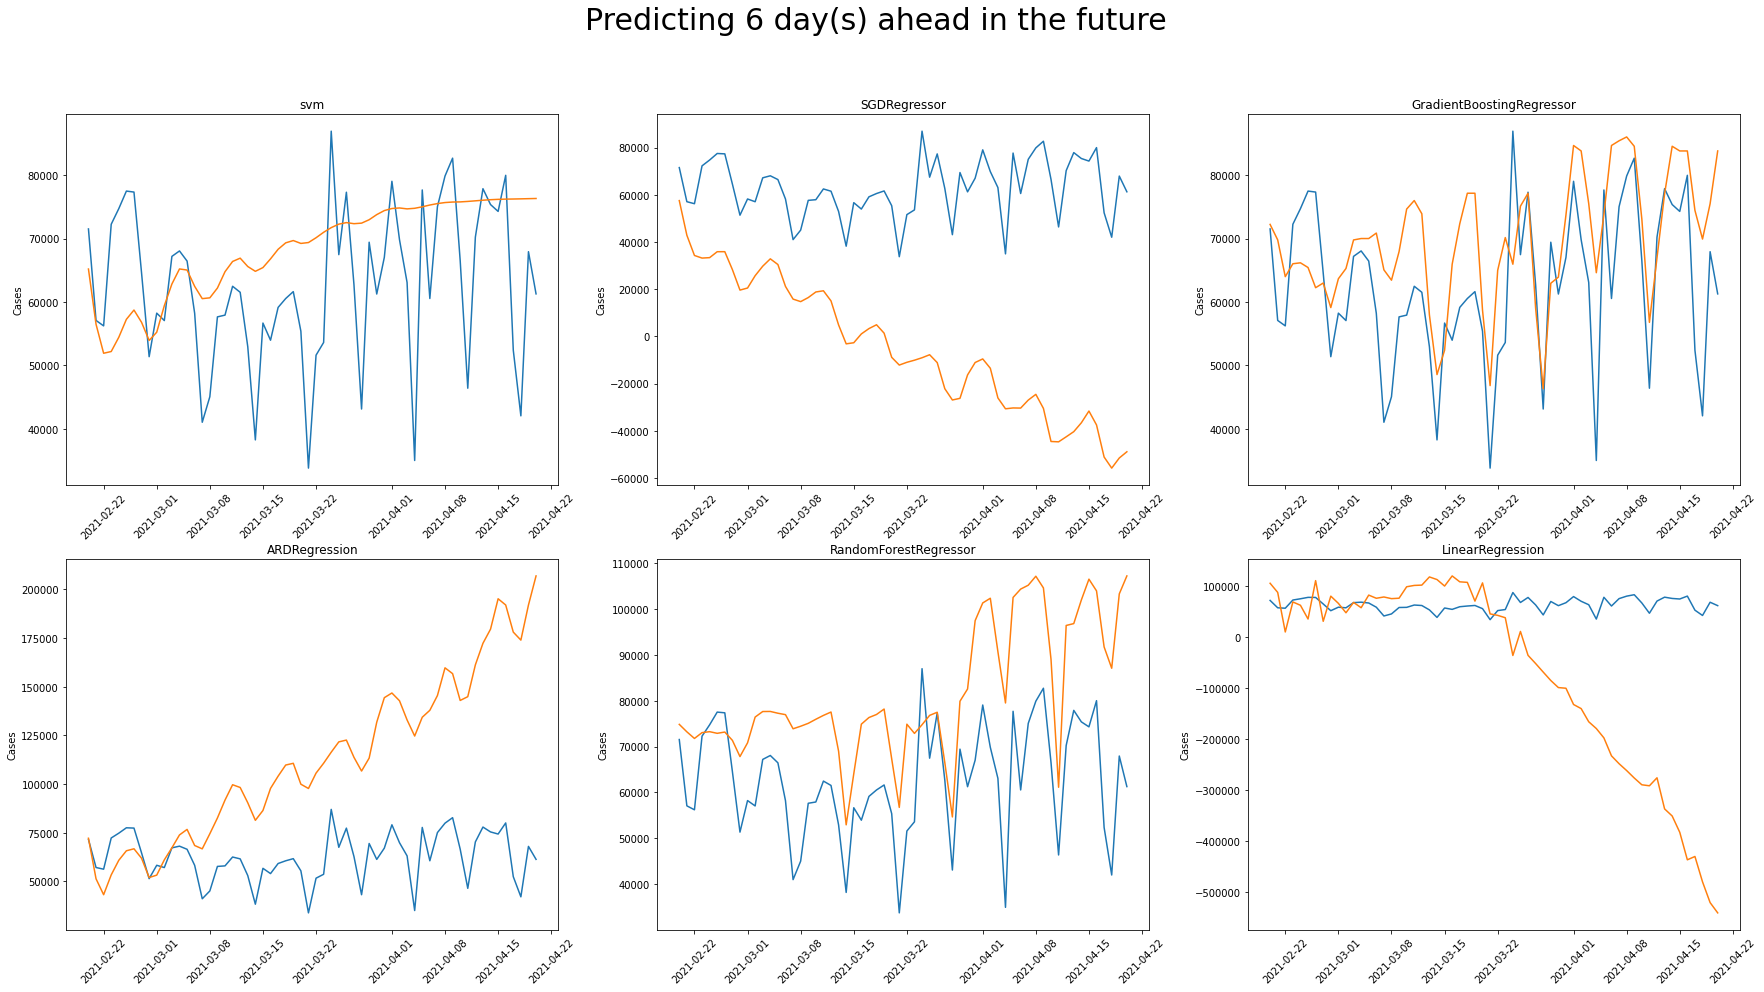

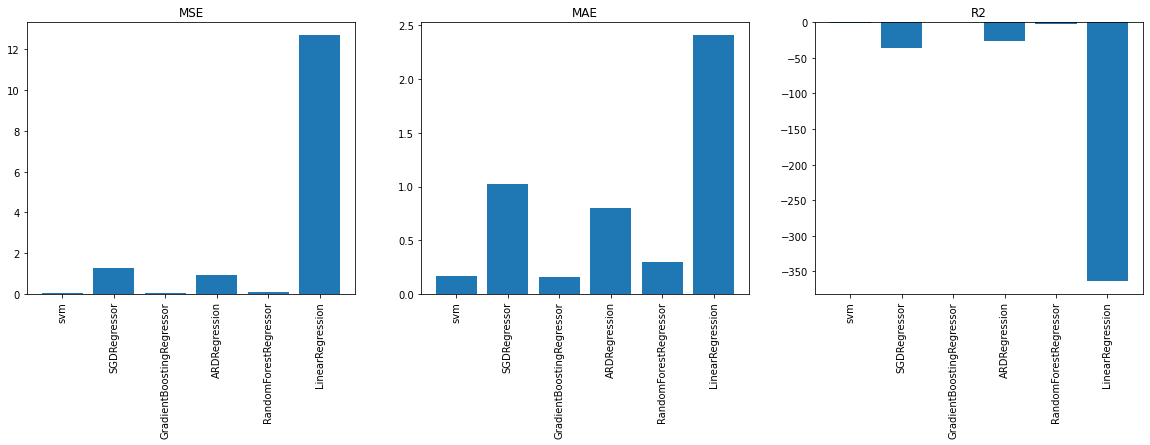

trainX shape == (403, 7, 8).
trainY shape == (403, 1).
trainX shape == (343, 7, 8).
trainY shape == (343, 1).
testX shape == (60, 7, 8).
testY shape == (60, 1).
trainX shape == (403, 7, 8).
trainY shape == (403, 1).
trainX shape == (343, 7, 8).
trainY shape == (343, 1).
testX shape == (60, 7, 8).
testY shape == (60, 1).


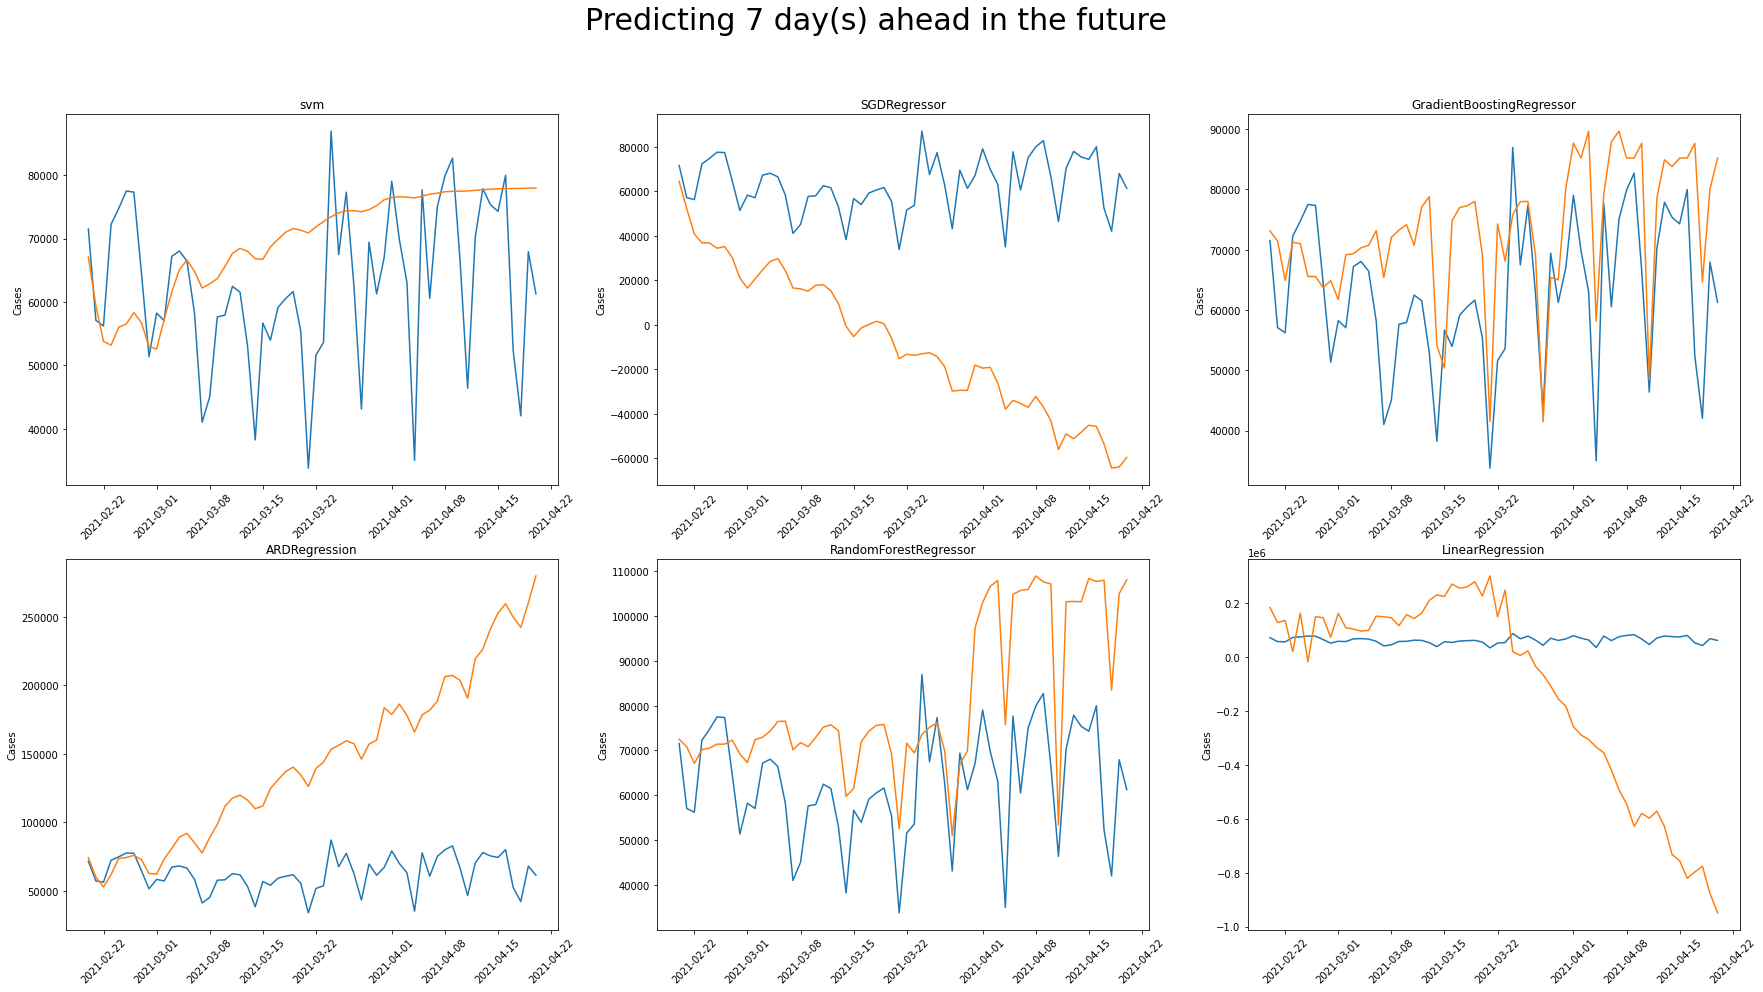

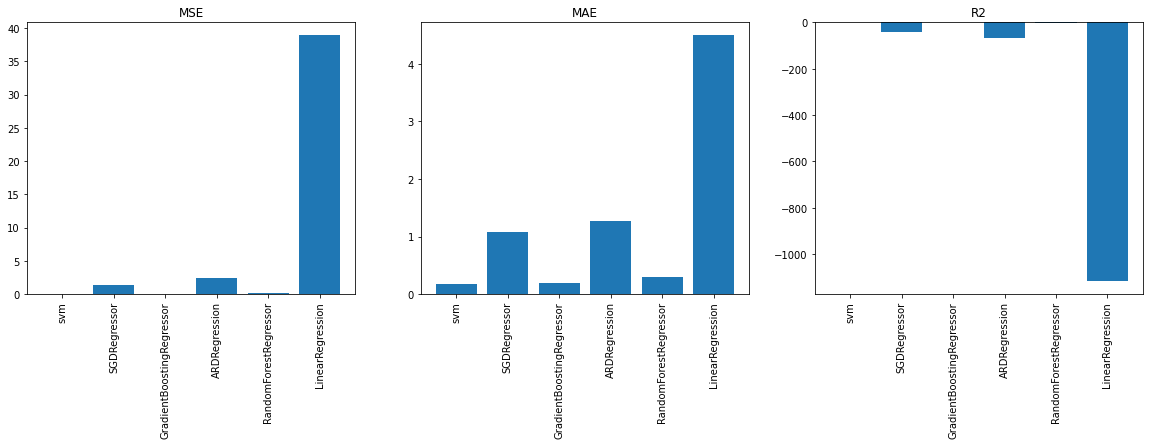

In [ ]:
for i in range(1,8):
    trainX_new, trainY_new = set_shape(i)
    testX_new, testY_new,trainDates, testDates, trainX_new,trainY_new = test_train_split(trainX_new, trainY_new)
    a,b = set_shape2(i)
    testX_new, testY_new,trainDates, testDates, trainX_new2,trainY_new2 = test_train_split(a, b)
    predict_n_days(trainX_new, trainY_new, testX_new, testY_new, testDates,i)